# tracking the detected pupil: visual inspection of the results



In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline

### Using 42 frames recorded with 2015-11-05 notebook


In [2]:
import cv2
import os

N_frame = 42

folder = '/tmp/debug'
H, W, three = cv2.imread(os.path.join(folder, 'frame_1.png')).shape

movie = np.zeros((H, W, 3, N_frame), dtype=np.uint8)

for i in range(N_frame):
    fname = 'frame_{i}.png'.format(i=i)
    movie[:, :, :, i] = cv2.cvtColor(cv2.imread(os.path.join(folder, fname)), cv2.COLOR_BGR2RGB)


AttributeError: 'NoneType' object has no attribute 'shape'

(720, 1280, 3, 42) 0 255


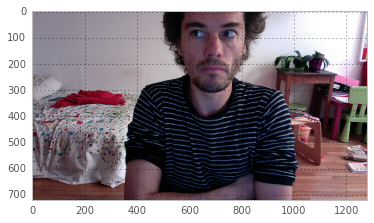

In [7]:
print(movie.shape, movie.min(), movie.max())
plt.imshow(movie[:, :, :, 0])

## averaging the background from this first pass

We take the borders of the face to retrieve the fine motion of the face.

In [8]:
from LeCheapEyeTracker import Client, Server
et = Server()
#img_ = movie[:, :, :, 0].copy()

#import time
#start = time.time()
from LeCheapEyeTracker.constants import eye_image as eye_template

v_border = (.2, .4)
h_border = (.38, .45)
# learn 
for i_t in range(N_frame):
    img_ = movie[:, :, :, i_t].copy()
    (x, y, w, h), minNeighbors = et.get_just_one(img_)

    half_w, quarter_w = w//2, w//4
    img_face = img_[(y+quarter_w):(y+quarter_w+half_w), x:x+half_w]
    img_face = cv2.resize(img_face, (et.head_size//2, et.head_size//2))

    if i_t==0: 
        face_template_v = cv2.Sobel(img_face, cv2.CV_32F,0,1,ksize=5)[int(et.head_size*.2):int(et.head_size*.4), :, :]
    else:
        face_template_v += cv2.Sobel(img_face, cv2.CV_32F,0,1,ksize=5)[int(et.head_size*.2):int(et.head_size*.4), :, :]
            
    if i_t==0: 
        face_template_h = cv2.Sobel(img_face, cv2.CV_32F,1,0,ksize=5)[:, int(et.head_size*h_border[0]):int(et.head_size*h_border[1]), :]
    else:
        face_template_h += cv2.Sobel(img_face, cv2.CV_32F,1,0,ksize=5)[:, int(et.head_size*h_border[0]):int(et.head_size*h_border[1]), :]


    res = cv2.matchTemplate(img_face, eye_template, cv2.TM_CCOEFF)
    min_val, max_val_, min_loc, max_loc = cv2.minMaxLoc(res)
    #w, h = eye_template.shape[1], eye_template.shape[0]
    #bottom_right = (max_loc[0] + w, max_loc[1] + h)

    weight = 1. #(max_val[i_t-max_val.min())/(max_val.max()-max_val.min())
    if i_t==0: 
        eye_template_ = weight * img_face[max_loc[1]:max_loc[1] + ht, max_loc[0]:max_loc[0] + wt].astype(np.float64)
    else:
        eye_template_ += weight * img_face[max_loc[1]:max_loc[1] + ht, max_loc[0]:max_loc[0] + wt].astype(np.float64)


eye_template_ = (eye_template_-eye_template_.min())/(eye_template_.max()-eye_template_.min())*255
eye_template_ = eye_template_.astype(np.uint8)

#apply
for i_t in range(N_frame):
    img_ = movie[:, :, :, i_t].copy()
    (x, y, w, h), minNeighbors = et.get_just_one(img_)

    half_w, quarter_w = w//2, w//4
    img_face = img_[(y+quarter_w):(y+quarter_w+half_w), x:x+half_w]
    img_face = cv2.resize(img_face, (et.head_size//2, et.head_size//2))

    res = cv2.matchTemplate(img_face, eye_template_, cv2.TM_CCOEFF)
#    res = cv2.matchTemplate(cv2.Sobel(img_face, cv2.CV_32F,1,0,ksize=3), cv2.Sobel(eye_template_, cv2.CV_32F,1,0,ksize=3), cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    bottom_right = (max_loc[0] + wt, max_loc[1] + ht)

    # detect vertical shift
    img_face_v = cv2.Sobel(img_face, cv2.CV_32F, 0, 1, ksize=5)
    res = cv2.matchTemplate(img_face_v, face_template_v, cv2.TM_CCOEFF)
    __min_val, __max_val, _min_loc, face_max_loc = cv2.minMaxLoc(res)
    face_v_top_left = (0, face_max_loc[1] - 1)
    face_v_bottom_right = (et.head_size, face_max_loc[1] + 1)

    # detect horizontal shift
    res = cv2.matchTemplate(cv2.Sobel(img_face, cv2.CV_32F,1,0,ksize=5), face_template_h, cv2.TM_CCOEFF)
    __min_val, __max_val, _min_loc, face_max_loc = cv2.minMaxLoc(res)
    face_h_top_left = (face_max_loc[0] - 1, 0)
    face_h_bottom_right = (face_max_loc[0] + 1, et.head_size)

    cv2.rectangle(img_face, max_loc, bottom_right, 255, 2)
    cv2.rectangle(img_face, face_h_top_left, face_h_bottom_right, 127, 2)
    cv2.rectangle(img_face, face_v_top_left, face_v_bottom_right, 127, 2)
    fig, axs = plt.subplots(1, 1, figsize=(9, 9))
    axs.imshow(img_face)
    axs.set_title(max_loc[0] - face_max_loc[0])


IndexError: tuple index out of range